In [ ]:
!pip install -U scikit-learn -i https://pypi.tuna.tsinghua.edu.cn/simple

In [94]:
import tensorflow as tf
import api.capital_features_api as cf
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, InputLayer, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import backend as K

scaler = StandardScaler()
tf.config.list_physical_devices(device_type='GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [78]:
train_data = cf.get_train_data(cf.prod_train_data_url, train_config_id=41146)
validation_data = cf.get_train_data(cf.prod_train_data_url, train_config_id=41147)

In [79]:
X_train = np.array(train_data['featuresT'])
X_val = np.array(validation_data['featuresT'])

In [80]:
# 获取形状信息
num_samples, num_timesteps, num_features = X_train.shape
# 将三维特征数组重塑为二维
X_train_reshaped = X_train.reshape(-1, num_features)
# 使用训练集的数据来拟合scaler
scaler.fit(X_train_reshaped)

# 标准化训练数据
X_train_scaled = scaler.transform(X_train_reshaped).reshape(num_samples, num_timesteps, num_features)
# 同样的，将验证集（如果有的话）重塑并转换
num_samples_val, num_timesteps_val, num_features_val = X_val.shape
X_val_reshaped = X_val.reshape(-1, num_features_val)
X_val_scaled = scaler.transform(X_val_reshaped).reshape(num_samples_val, num_timesteps_val, num_features_val)

In [81]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, train_data['upSignals']))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_val_scaled, validation_data['upSignals']))
BATCH_SIZE = 64  # 你可以根据需要调整这个值
train_dataset = train_dataset.batch(BATCH_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)

In [82]:
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data['upSignals']),
    y=train_data['upSignals']
)
class_weights = dict(zip(np.unique(train_data['upSignals']), weights))

In [109]:
def max_acc(y_true, y_pred):
    # 设定一个阈值来确定分类（例如，0.5）
    threshold = 0.5
    y_pred = tf.cast(y_pred >= threshold, tf.float32)
    
    # 这里，我们将False Negatives的权重设为0，也就是说它们不计入总的损失
    fn_weight = 0.2
    fp_weight = 1.0  # False Positives的权重
    tn_weight = 1.0  # True Negatives的权重
    tp_weight = 1.0  # True Positives的权重
    
    # 计算不同类型错误的数量
    tp = K.sum(tp_weight * y_true * y_pred)
    fp = K.sum(fp_weight * (1 - y_true) * y_pred)
    fn = K.sum(fn_weight * y_true * (1 - y_pred))
    tn = K.sum(tn_weight * (1 - y_true) * (1 - y_pred))
    
    # 计算自定义评估指标
    # 在这个例子中，我们只计算被正确分类的样本的比例作为评估指标
    custom_score = (tp + tn) / (tp + fp + fn + tn)
    return custom_score

In [113]:
model = Sequential([
    tf.keras.layers.InputLayer(input_shape=(6, 71)),
    LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    BatchNormalization(),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    BatchNormalization(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(1, activation='sigmoid'),
])

model.summary()
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall', max_acc]
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=20,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.5,
    patience=4,
    min_lr=1e-5,
    verbose=1
)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 6, 128)            102400    
                                                                 
 dropout_64 (Dropout)        (None, 6, 128)            0         
                                                                 
 batch_normalization_38 (Bat  (None, 6, 128)           512       
 chNormalization)                                                
                                                                 
 lstm_29 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_65 (Dropout)        (None, 64)                0         
                                                                 
 batch_normalization_39 (Bat  (None, 64)               256       
 chNormalization)                                    

In [114]:
his_up = model.fit(train_dataset, epochs=100, validation_data=validation_dataset, verbose=1,
                   callbacks=[early_stopping, reduce_lr], class_weight=class_weights)

Epoch 1/100
313/313 [==============================] - 9s 19ms/step - loss: 0.8616 - accuracy: 0.5805 - precision: 0.4845 - recall: 0.5709 - max_acc: 0.6749 - val_loss: 0.8498 - val_accuracy: 0.5403 - val_precision: 0.4946 - val_recall: 0.0383 - val_max_acc: 0.8239 - lr: 0.0010
Epoch 2/100
313/313 [==============================] - 5s 16ms/step - loss: 0.7650 - accuracy: 0.6197 - precision: 0.5250 - recall: 0.6330 - max_acc: 0.7031 - val_loss: 0.8796 - val_accuracy: 0.5427 - val_precision: 0.5362 - val_recall: 0.0311 - val_max_acc: 0.8294 - lr: 0.0010
Epoch 3/100
313/313 [==============================] - 5s 17ms/step - loss: 0.7153 - accuracy: 0.6428 - precision: 0.5492 - recall: 0.6552 - max_acc: 0.7230 - val_loss: 0.8097 - val_accuracy: 0.5419 - val_precision: 0.5068 - val_recall: 0.0933 - val_max_acc: 0.8043 - lr: 0.0010
Epoch 4/100
313/313 [==============================] - 5s 17ms/step - loss: 0.6740 - accuracy: 0.6664 - precision: 0.5746 - recall: 0.6768 - max_acc: 0.7439 - val_

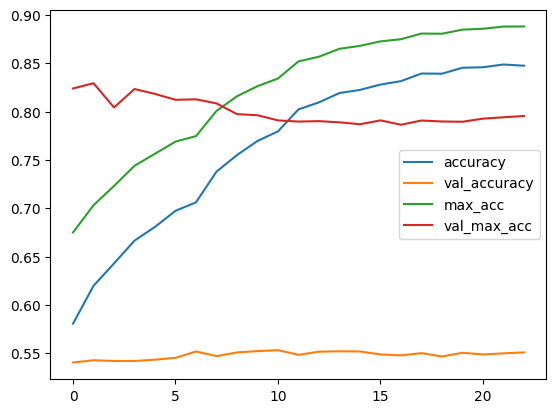

In [118]:
plt.plot(his_up.history['accuracy'], label='accuracy')
plt.plot(his_up.history['val_accuracy'], label='val_accuracy')
plt.plot(his_up.history['max_acc'], label='max_acc')
plt.plot(his_up.history['val_max_acc'], label='val_max_acc')
plt.legend()
plt.show()

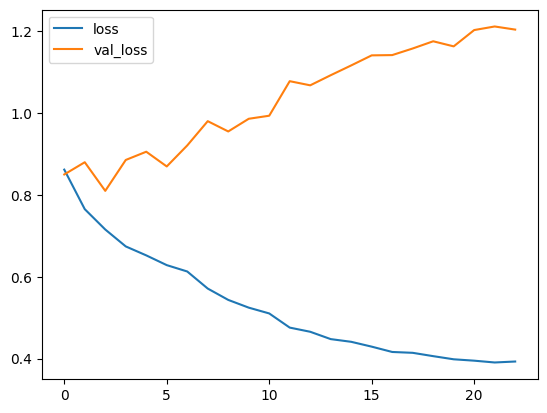

In [117]:
plt.plot(his_up.history['loss'], label='loss')
plt.plot(his_up.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [43]:
len(validation_data['upSignals'])

5300

In [44]:
validation_data['upSignals'].count(1)

2428

In [45]:
validation_data['upSignals'].count(0)

2872